# ITCS 6010/8010 Assignment1
**Due date: 11:59 pm EDT on Sep 20, 2024 (Fri.)**

---
For this course, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your UNC Charlotte (*.uncc.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This codebase provides an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

In this assignment you will train a deep convolutional network to recognize scenes. The starter codes gives you methods to load data and display them. Here, we will define a simple network architecture that achieves accuracy less than 50%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features. 


This is an approach that represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do).

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>


## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [66]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

## Loading and Preprocessing data
---
In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. 

In [67]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

import albumentations

def set_random_seed(seed):
   torch.manual_seed(seed)
   torch.cuda.manual_seed_all(seed)
   np.random.seed(seed)
   random.seed(seed)
   torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
       augment=False, is_color=False, zero_centered=False, mirror=False, rotate=False, together=False):
  set_random_seed(0)
  data = []
  labels = []
  channel_num = 3 if is_color else 1

  # read images and resizing
  for id, class_name in class_names.items():
    print("Loading images from class: %s" % id)
    img_path_class = glob.glob(path + class_name + '/*.jpg')
    if num_per_class > 0:
      img_path_class = img_path_class[:num_per_class]
    labels.extend([id]*len(img_path_class))
    for filename in img_path_class:
      if is_color:
        img = cv2.imread(filename)
      else:
        img = cv2.imread(filename, 0)

      # resize the image
      img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

      if is_color:
        img = np.transpose(img, [2, 0, 1])

      # norm pixel values to [-1, 1]
      data.append(img.astype(np.float64)/255*2-1)

  # Data Augmentation

  if augment:
    aug_mirror = albumentations.Compose(
      [
        albumentations.HorizontalFlip(p=1),
      ],
    )

    aug_rotate = albumentations.Compose(
      [
        albumentations.Rotate(p=1, border_mode=0, limit=30),
      ],
    )


    dataset_length = len(data)

    if mirror and not rotate:
      for i in range(dataset_length):

        img_temp = aug_mirror(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])


    if rotate and not mirror:
      for i in range(dataset_length):

        img_temp = aug_rotate(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])


    if  mirror and rotate:
      for i in range(dataset_length):

        img_temp = aug_mirror(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])

      for i in range(dataset_length):

        img_temp = aug_rotate(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])


    if together:
      for i in range(dataset_length):

        img_temp = aug_mirror(image=data[i])['image']
        img_temp = aug_rotate(image=img_temp)['image']

        data.append(img_temp)
        labels.append(labels[i])


  # Data Normalization
  if zero_centered:
    if is_color:
      for i,image in enumerate(data):
        data[i][0] += np.mean(image[0])
        data[i][1] += np.mean(image[1])
        data[i][2] += np.mean(image[2])
    else:
      for i,image in enumerate(data):
        data[i] += np.mean(image)
    # pass


  # randomly permute (this step is important for training)
  if shuffle:
    bundle = list(zip(data, labels))
    random.shuffle(bundle)
    data, labels = zip(*bundle)

  # divide data into minibatches of TorchTensors
  if batch_size > 1:
    batch_data = []
    batch_labels = []

    for i in range(int(len(data) / batch_size)):
      minibatch_d = data[i*batch_size: (i+1)*batch_size]
      minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
      batch_data.append(torch.from_numpy(minibatch_d))

      minibatch_l = labels[i*batch_size: (i+1)*batch_size]
      batch_labels.append(torch.LongTensor(minibatch_l))
    data, labels = batch_data, batch_labels

  return zip(batch_data, batch_labels)

class_names: {0: 'Forest', 1: 'Bedroom', 2: 'Office', 3: 'Highway', 4: 'Flower', 5: 'Coast', 6: 'InsideCity', 7: 'TallBuilding', 8: 'Industrial', 9: 'Street', 10: 'LivingRoom', 11: 'Suburb', 12: 'Mountain', 13: 'Kitchen', 14: 'OpenCountry', 15: 'Store'} 


In [68]:
# load data into size (224, 224)
img_size = (224, 224)
batch_size = 32 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, mirror=True, rotate=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 225 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from cl

Highway


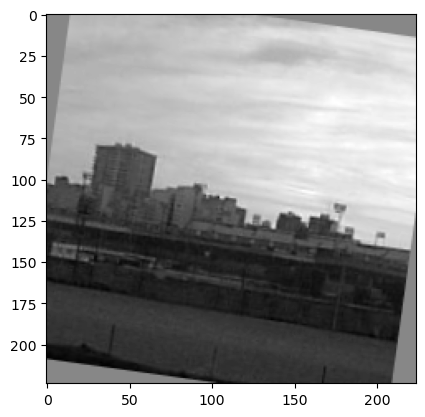

In [69]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Training a Network From Scratch
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a simpe network architecture.

In [98]:
import torchvision.models as models

#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------

class TNet(nn.Module):
    def __init__(self, num_classes=16):
        super(TNet, self).__init__()
        
        # Load the pre-trained ResNet model
        self.resnet = models.resnet50(pretrained=True)
        
        # Modify the first convolutional layer to accept 1-channel input if necessary
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze all layers initially
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Unfreeze the last few layers (example: layer4 and fc)
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True
        for param in self.resnet.fc.parameters():
            param.requires_grad = True
        
        # Replace the final fully connected layer to match the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
        # Ensure the final layer's parameters are trainable
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.resnet(x)
        
        
    
#--------------------------------------------------
#       Define Another Network Architecture
#--------------------------------------------------
    
class TNet2(nn.Module):
    def __init__(self, num_classes=16):
        super(TNet2, self).__init__()
        
        # Load the pre-trained DenseNet121 model
        self.densenet = models.densenet121(pretrained=True)
        
        # Modify the first convolutional layer to accept 1-channel input if necessary
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=3, bias=False)
        
        # Freeze all layers initially
        for param in self.densenet.parameters():
            param.requires_grad = False
        
        # Unfreeze more layers (example: unfreeze layers in denseblock3 and denseblock4)
        for param in self.densenet.features.denseblock3.parameters():
            param.requires_grad = True
        for param in self.densenet.features.denseblock4.parameters():
            param.requires_grad = True
        
        # Replace the final fully connected layer to match the number of classes
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.densenet.classifier.in_features, num_classes)
        )
        
        # Ensure the final layer's parameters are trainable
        for param in self.densenet.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.densenet(x)
        return x
    
#--------------------------------------------------
#       Define VGG16 Network Architecture
#--------------------------------------------------

class TNet3(nn.Module):
    def __init__(self, num_classes=16):
        super(TNet3, self).__init__()
        
        # Load the pre-trained VGG16 model
        self.vgg = models.vgg16(pretrained=True)
        
        # Modify the first convolutional layer to accept 1-channel input if necessary
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        
        # Freeze all layers initially
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        # Unfreeze some layers
        for param in self.vgg.features[:10].parameters():
            param.requires_grad = True
        
        # Replace the final fully connected layer to match the number of classes
        self.vgg.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.vgg.classifier[6].in_features, num_classes)
        )
        
        # Ensure the final layer's parameters are trainable
        for param in self.vgg.classifier[6].parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.vgg(x)
        return x

#--------------------------------------------------
#       Define Ensemble Model
#--------------------------------------------------

class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB, modelC):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC

    def forward(self, x):
        outputA = self.modelA(x)
        outputB = self.modelB(x)
        outputC = self.modelC(x)
        return (outputA + outputB + outputC) / 3

# Initialize the individual models
modelA = TNet(num_classes=16)
modelB = TNet2(num_classes=16)
modelC = TNet3(num_classes=16)

# Create the ensemble model
ensemble_model = EnsembleModel(modelA, modelB, modelC)

Then, let's define model training and evaluation functions.

In [99]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time

def trainModel(net, trainloader, train_option, testloader=None):
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1

  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()

  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Learning Rate: {} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, scheduler.get_last_lr()[0],iter, time_lapse, loss.item(), running_loss/iters))

    scheduler.step()
    
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [100]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time

def evalModel(net, testloader):
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()

  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)

  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))


Finally, let's start training and evaluation.

In [101]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
train_option = {}
train_option['epoch'] = 12
train_option['device'] = 'cpu'

# Test with learning rate 0.001
train_option['lr'] = 0.001
print("Training with learning rate 0.001")
trainModel(modelA, trainloader_small, train_option, testloader_small)


Training with learning rate 0.001
Epoch: 1 | Learning Rate: 0.001 | Iter:    0 | Time: 00:00:05 | Train Loss: 2.7381 | Average Loss: 2.7381 
Epoch: 1 | Learning Rate: 0.001 | Iter:   20 | Time: 00:01:41 | Train Loss: 2.0483 | Average Loss: 2.3778 
Epoch: 1 | Learning Rate: 0.001 | Iter:   40 | Time: 00:03:15 | Train Loss: 1.5771 | Average Loss: 2.1659 
Epoch: 1 | Learning Rate: 0.001 | Iter:   60 | Time: 00:04:48 | Train Loss: 1.4055 | Average Loss: 2.0157 
Epoch: 1 | Learning Rate: 0.001 | Iter:   80 | Time: 00:06:23 | Train Loss: 1.2550 | Average Loss: 1.9519 
Epoch: 1 | Learning Rate: 0.001 | Iter:  100 | Time: 00:08:01 | Train Loss: 1.4225 | Average Loss: 1.8647 
Epoch: 1 | Learning Rate: 0.001 | Iter:  120 | Time: 00:09:34 | Train Loss: 1.2725 | Average Loss: 1.7912 
Epoch: 1 | Learning Rate: 0.001 | Iter:  140 | Time: 00:11:06 | Train Loss: 1.3640 | Average Loss: 1.7325 
Epoch: 1 | Learning Rate: 0.001 | Iter:  160 | Time: 00:12:39 | Train Loss: 1.1459 | Average Loss: 1.6737 
Epo

KeyboardInterrupt: 

Great! You would get around 0.45-0.50 accuracy by this very simple network. Now it's your job to beat this result.

## Submission guidelines
---
Please submit a pdf file that includes a ***gitlab link*** of your codes. This pdf file should be named as **Surname_Givenname_UNCCID_assignment1.pdf** (example: Jordan_Michael_800134567_assignment1.pdf for this assignment). This pdf will be used for a similarity checking of your codes.


You are encouraged to post and answer questions on Canvas. Please ask questions on Canvas and send emails to the instructor only for personal issues.


Be aware that your report will undergo plagiarism check both vertically and horizontally. Please do not duplicate your reports from your classmates.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have THREE days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.